In [1]:
import numpy as np
import sipm.sipm as sipm
import sipm.dataset as ds
import sipm.beta as beta
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sipm.sipm import pulse_jitter
import sipm.constants as const
from scipy.fft import fft, ifft
import ROOT
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Welcome to JupyROOT 6.26/06


In [2]:
!pwd

/home/as111/sipm-analysis


In [3]:
def scintillation_pulse(t, a_s, tau_s, a_t, tau_t, sigma, t0):
        return pulse_jitter(t, a_s, tau_s, sigma, t0) + pulse_jitter(t, a_t, tau_t, sigma, t0)

# Read SPE Waveform (65V)

In [4]:
pos = ['top', 'bottom']
spe_graph = []
spe_fft = []
for i,p in enumerate(pos):
    spe_pos = []
    spe_fft_pos = []
    for ch in range(4):
        file = ROOT.TFile('root/SPE_waveform_1122_65V_{}.root'.format(p))
        spe_ch = file.Get('gSPE_ch{}'.format(ch))
        spe_pos.append(spe_ch)
        file.Close()
        tpeak = np.argmax(np.array(list(spe_ch.GetY())))
        spe_fft_ch = fft(np.array(list(spe_ch.GetY())))
        for f in range(len(spe_fft_ch)):
            spe_fft_ch[f] *= np.exp(complex(0,2*np.pi*f*tpeak/len(spe_ch.GetY())))
        spe_fft_pos.append(spe_fft_ch)
    spe_graph.append(spe_pos)
    spe_fft.append(spe_fft_pos)
time = np.array(list(spe_graph[0][0].GetX()))
dt = time[1]-time[0]
freq = np.arange(time.size)/dt/time.size

(0.0, 124.96874406430315)

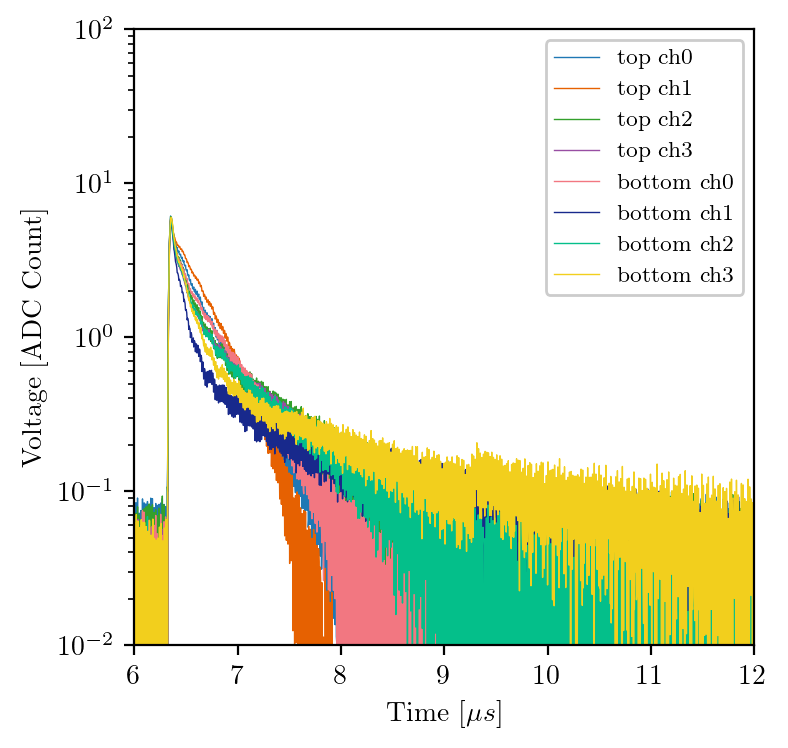

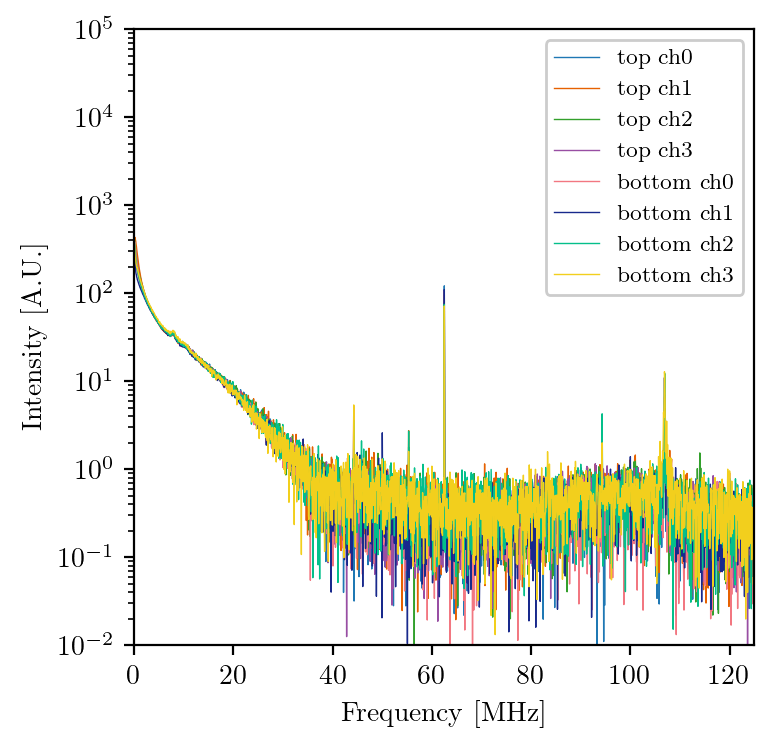

In [5]:
plt.figure(1,figsize=(4,4))
for i,p in enumerate(pos):
    for ch in range(4):
        plt.plot(list(spe_graph[i][ch].GetX()), list(spe_graph[i][ch].GetY()), label='{} ch{}'.format(p,ch), linewidth=0.5)
plt.legend(loc='upper right')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel(r'Voltage [ADC Count]')
plt.yscale('log')
plt.ylim(1e-2, 1e2)
plt.xlim(6,12)

plt.figure(2,figsize=(4,4))
for i,p in enumerate(pos):
    for ch in range(4):
        plt.plot(freq, abs(spe_fft[i][ch]), label='{} ch{}'.format(p,ch), linewidth=0.5)
plt.legend(loc='upper right')
plt.xlabel(r'Frequency [MHz]')
plt.ylabel(r'Intensity [A.U.]')
plt.yscale('log')
plt.ylim(1e-2,1e5)
plt.xlim(0,freq[-1]/2)

# 11/20 Triplet lifetime

ch0 A_S=1.12+/-0.05  TAU_S=0.0172+/-0.0010us  A_T=0.08+/-0.00  TAU_T=1.219+/-0.081us sigma=0.0031+/-0.0003us t0=6.276+/-0.000us
ch1 A_S=1.35+/-0.04  TAU_S=0.0193+/-0.0009us  A_T=0.10+/-0.00  TAU_T=1.300+/-0.069us sigma=0.0033+/-0.0003us t0=6.275+/-0.000us
ch2 A_S=1.23+/-0.05  TAU_S=0.0175+/-0.0009us  A_T=0.09+/-0.00  TAU_T=1.242+/-0.072us sigma=0.0031+/-0.0003us t0=6.276+/-0.000us
ch3 A_S=1.29+/-0.07  TAU_S=0.0153+/-0.0011us  A_T=0.09+/-0.01  TAU_T=1.254+/-0.100us sigma=0.0032+/-0.0004us t0=6.280+/-0.000us
ch0 A_S=5.42+/-0.18  TAU_S=0.0204+/-0.0009us  A_T=0.39+/-0.02  TAU_T=1.514+/-0.080us sigma=0.0032+/-0.0003us t0=6.288+/-0.000us
ch1 A_S=5.47+/-0.32  TAU_S=0.0176+/-0.0013us  A_T=0.41+/-0.02  TAU_T=1.334+/-0.103us sigma=0.0038+/-0.0004us t0=6.288+/-0.000us
ch2 A_S=7.60+/-0.27  TAU_S=0.0170+/-0.0008us  A_T=0.49+/-0.02  TAU_T=1.526+/-0.079us sigma=0.0037+/-0.0003us t0=6.280+/-0.000us
ch3 A_S=7.05+/-0.25  TAU_S=0.0191+/-0.0009us  A_T=0.55+/-0.02  TAU_T=1.301+/-0.067us sigma=0.0036+/-0.00

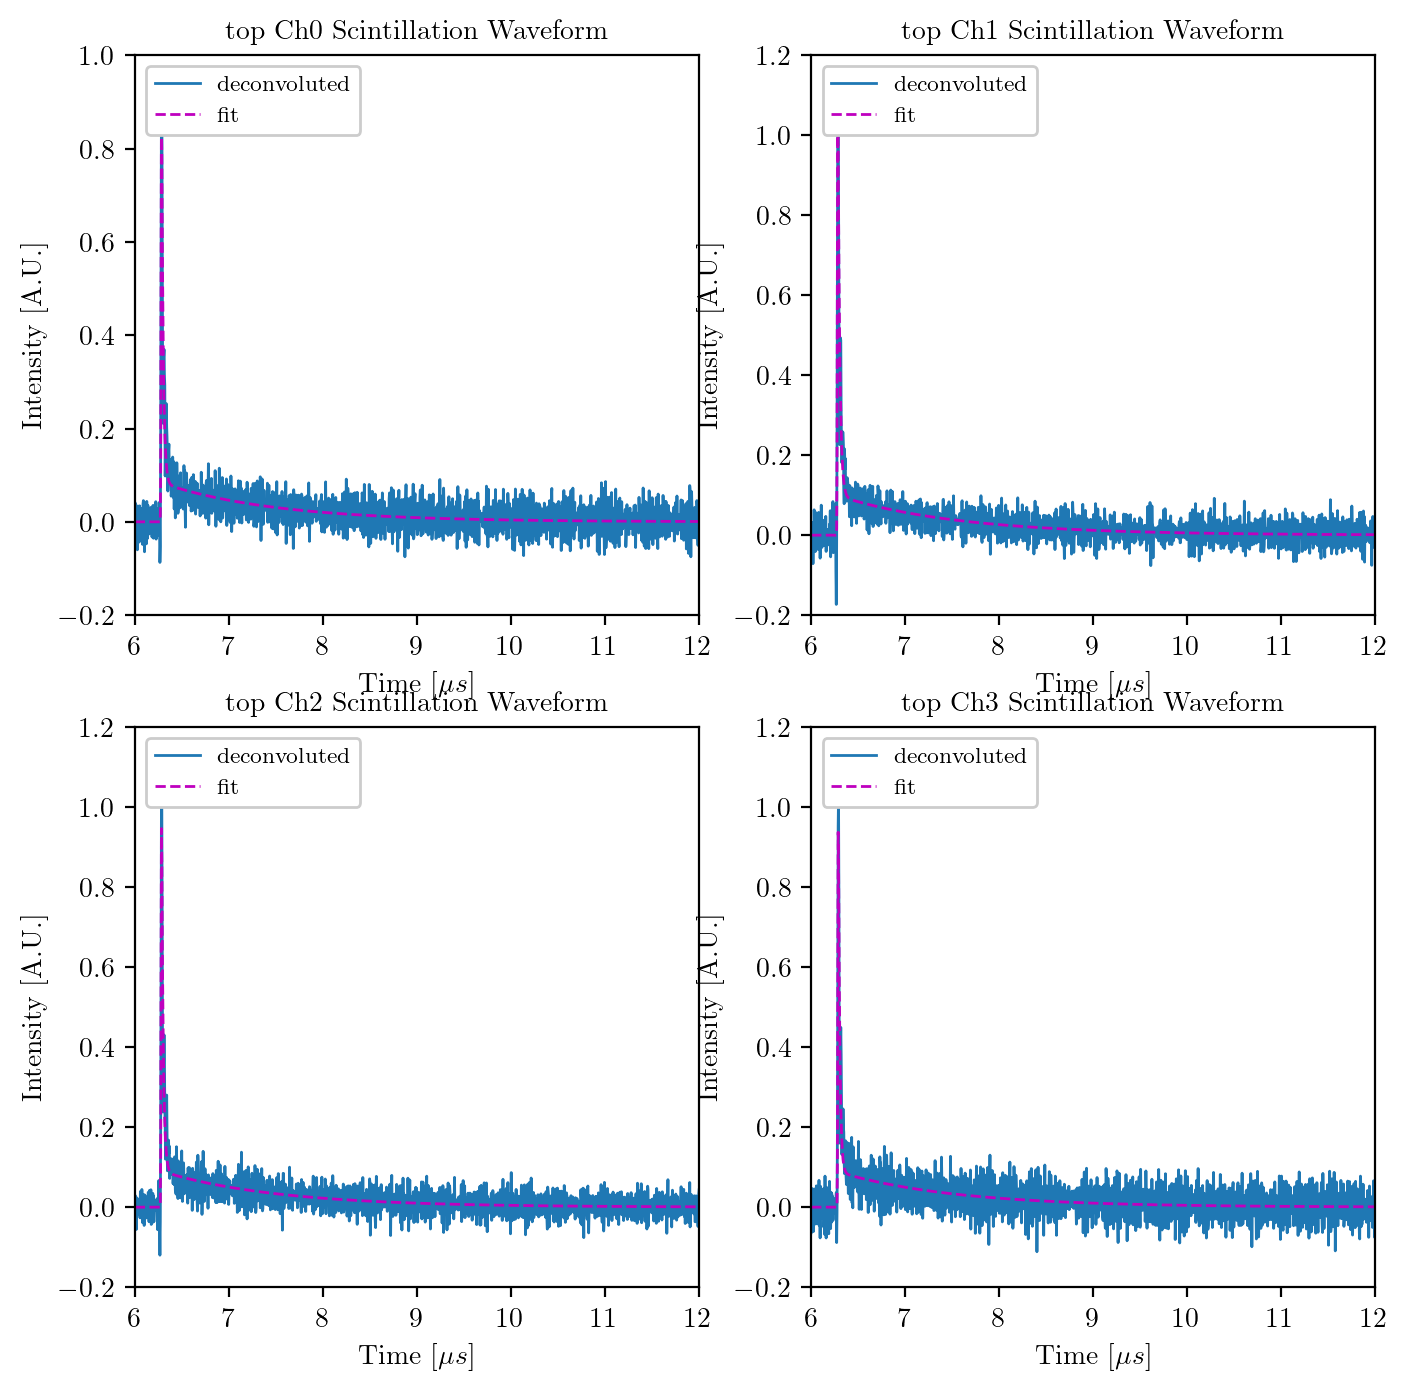

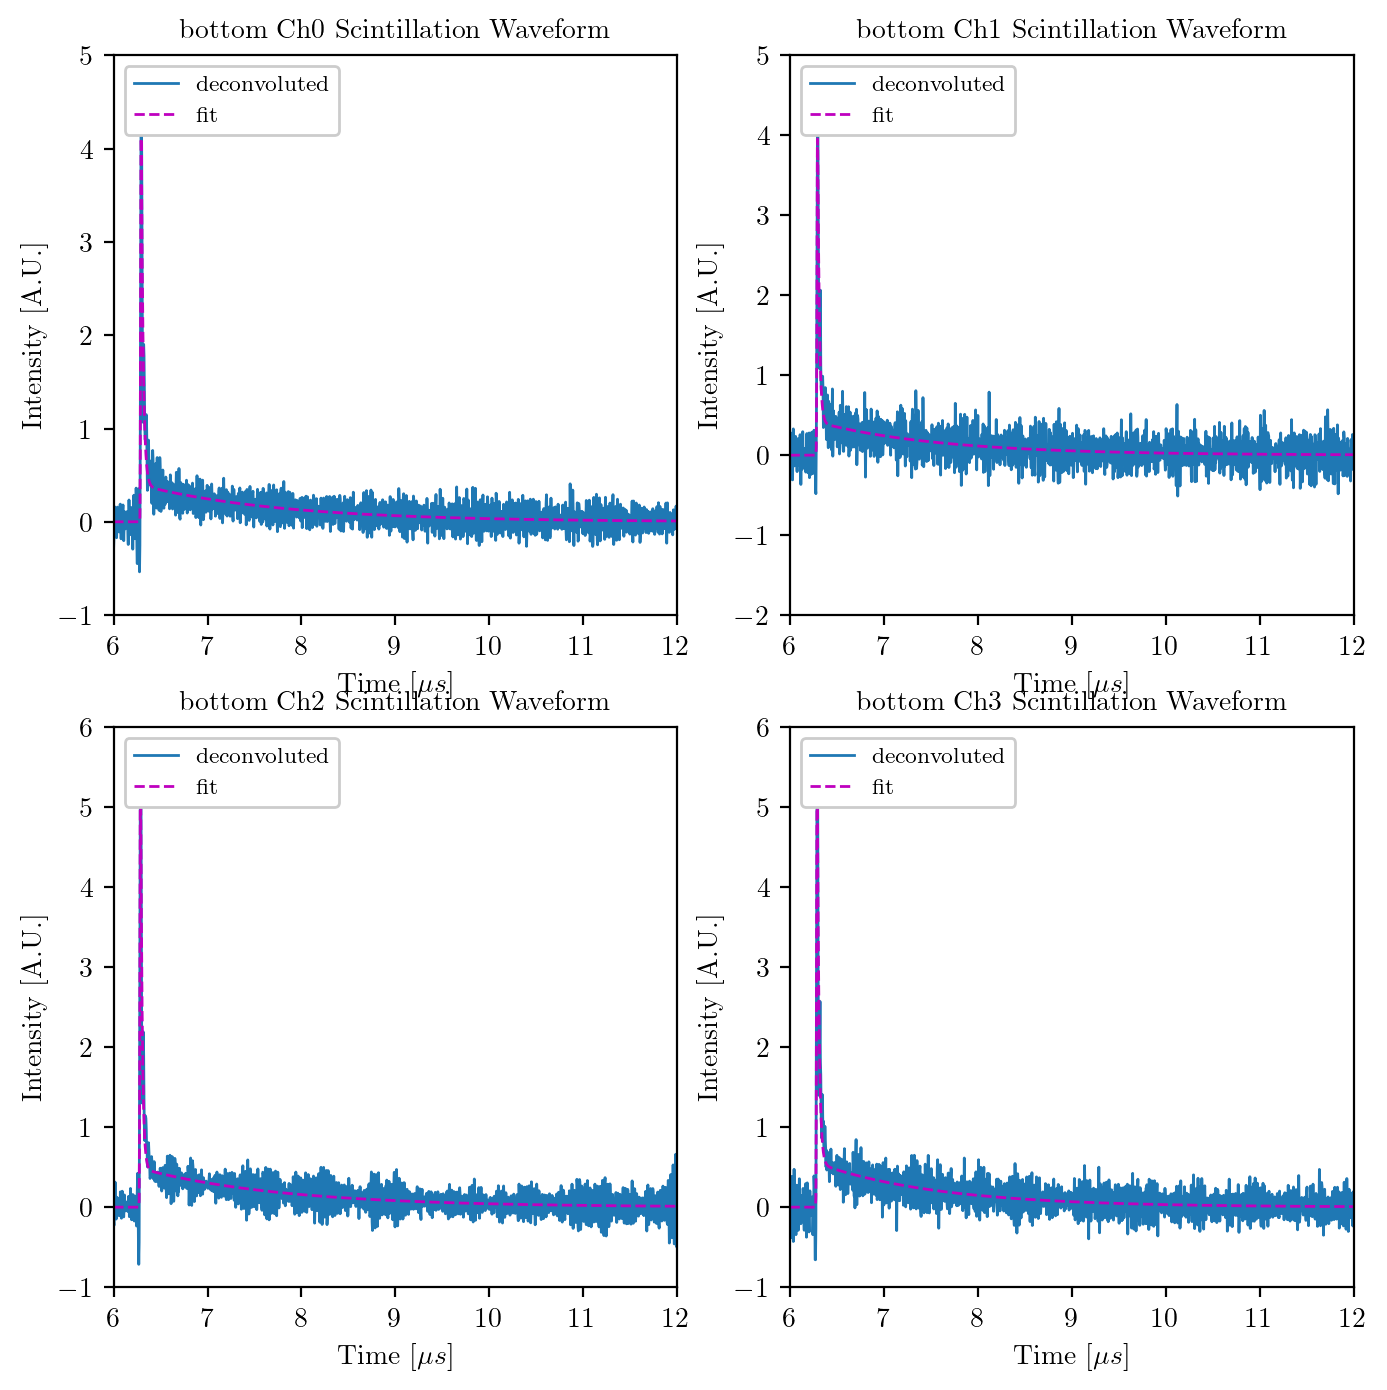

In [6]:
pos = ['top', 'bottom']
deconv1120 = []
triplet1120 = []
for i,p in enumerate(pos):
    deconv_pos = np.zeros(time.size)
    for ch in range(4):
        plt.figure(i,figsize=(8,8))
        file = ROOT.TFile('root/gamma_1120_65V_{}.root'.format(p))
        scint_graph = file.Get('gScintWf_ch{}'.format(ch))
        file.Close()
        deconv_ch = ifft(fft(np.array(list(scint_graph.GetY())))/spe_fft[i][ch]).real
        deconv_pos += deconv_ch

        t0 = np.argmax(deconv_ch)-int(0.1/dt)
        length = int(6/dt)
        bsl = np.argmax(deconv_ch)-int(0.5/dt)
        err = np.std(deconv_ch[:bsl])

        popt,pcov = curve_fit(scintillation_pulse,time[t0:t0+length], deconv_ch[t0:t0+length], p0=[1, 0.02, 0.1, 1.2, 0.01, 6.25], sigma=[err]*length, maxfev=100000)
        print('ch{} A_S={:.2f}+/-{:.2f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.2f}+/-{:.2f}  TAU_T={:.3f}+/-{:.3f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(ch,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
        
        plt.subplot(2,2,ch+1)
        plt.plot(time, deconv_ch, label='deconvoluted', linewidth=1)
        plt.plot(time, scintillation_pulse(time, *popt), "m--", label='fit', linewidth=1)
        plt.title('{} Ch{} Scintillation Waveform'.format(p,ch))
        plt.ylabel('Intensity [A.U.]')
        plt.xlabel(r'Time [$\mu s$]')
        plt.legend()
        plt.xlim(6,12)
    deconv1120.append(deconv_pos)

ch3 A_S=4.71+/-0.12  TAU_S=0.0189+/-0.0006us  A_T=0.35+/-0.01  TAU_T=1.283+/-0.049us sigma=0.0033+/-0.0002us t0=6.276+/-0.000us
ch3 A_S=22.99+/-0.52  TAU_S=0.0210+/-0.0006us  A_T=1.80+/-0.04  TAU_T=1.449+/-0.047us sigma=0.0040+/-0.0002us t0=6.284+/-0.000us


Text(0.5, 0.98, '1120 Data 65V')

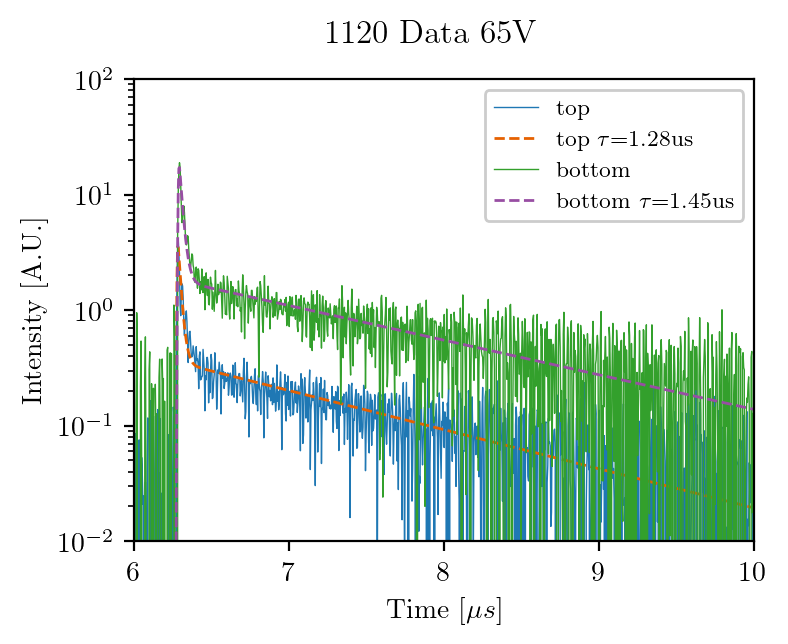

In [7]:
triplet1120 = []
for i,dc in enumerate(deconv1120):
    t0 = np.argmax(dc)-int(0.1/dt)
    length = int(6/dt)
    bsl = np.argmax(dc)-int(0.5/dt)
    err = np.std(dc[:bsl])

    popt,pcov = curve_fit(scintillation_pulse, time[t0:t0+length], dc[t0:t0+length], p0=[1, 0.02, 0.1, 1.2, 0.01, 6.25], sigma=[err]*length, maxfev=100000)
    print('ch{} A_S={:.2f}+/-{:.2f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.2f}+/-{:.2f}  TAU_T={:.3f}+/-{:.3f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(ch,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))

    triplet1120.append([popt[3], np.sqrt(pcov[3,3])])
    plt.plot(time, dc, '-', label=pos[i], linewidth=0.5)
    plt.plot(time[t0:t0+length], scintillation_pulse(time[t0:t0+length], *popt), '--', label=r'{} $\tau$={:.2f}us'.format(pos[i], popt[3]), linewidth=1)
    
plt.legend(loc='upper right')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel('Intensity [A.U.]')
plt.yscale('log')
plt.xlim(6, 10)
plt.ylim(1e-2, 1e2)
plt.suptitle('1120 Data 65V')

# Triplet lifetime evolution

In [8]:
files_top = [] #[date label, days since getter on]
for i in range(16):
    files_top.append(['1108_{}'.format(i),2.0+(5.0+i*1.05)/24.0]) #1h 3min apart
files_top.append(['1109',2.0+4.5/24.0])
files_top.append(['1110',3.0+3.5/24.0])
files_top.append(['1114',7.0+0.5/24.0])
files_top.append(['1115',8.0+0.5/24.0])
files_top.append(['1117',10.0+0.5/24.0])
files_top.append(['1118',11.0+4.5/24.0])
files_top.append(['1120',13.0+4.5/24.0])

files_bot = []
for i in range(6):
    files_bot.append(['1107_p{}'.format(i+1),i*45.0/60.0/24.0])
for i in range(14):
    files_bot.append(['1107_{}'.format(i),(5.0+i*1.05)/24.0])
files_bot.append(['1109',2.0-0.5/24.0])
files_bot.append(['1110',3.0+5.0/24.0])
for i in range(20):
    files_bot.append(['1110_{}'.format(i),3.0+(5.5+i*4.0)/24.0])
files_bot.append(['1115',8.0+6.0/24.0])
for i in range(6):
    files_bot.append(['1115_{}'.format(i),8.0+(6.0+i*3.0)/24.0])
files_bot.append(['1116',9.0+5.5/24.0])
for i in range(6):
    files_bot.append(['1116_{}'.format(i),9.0+(6.0+i*3.0)/24.0])
files_bot.append(['1117',10.0+5.0/24.0])
files_bot.append(['1118',11.0+5.5/24.0])
for i in range(11):
    files_bot.append(['1118_{}'.format(i),11.0+(6.0+i*4)/24.0])
files_bot.append(['1120',13.0+0.5/24.0])

files = [files_top, files_bot]

In [19]:
pos = ['top', 'bottom']
triplet = []
days = []

for i,p in enumerate(pos):
    triplet_pos = []
    days_pos = []
    for j,fs in enumerate(files[i]):
        dc = np.zeros(time.size)
        file = ROOT.TFile('root/gamma_{}_65V_{}.root'.format(fs[0],p))
        if not file.GetListOfKeys().Contains('gScintWf_ch0'):
            print('Bad file {}'.format(fs[0]))
            file.Close()
            continue

        for ch in range(4):
            scint_graph = file.Get('gScintWf_ch{}'.format(ch))
            deconv_ch = ifft(fft(np.array(list(scint_graph.GetY())))/spe_fft[i][ch]).real
            dc += deconv_ch
        file.Close()
        t0 = np.argmax(dc)-int(0.1/dt)
        length = int(6/dt)
        if(t0+length>=time.size or t0<0):
            continue
        bsl = np.argmax(dc)-int(0.5/dt)
        err = np.std(dc[:bsl])
        popt,pcov = curve_fit(scintillation_pulse, time[t0:t0+length], dc[t0:t0+length], p0=[1, 0.02, 0.1, 1.2, 0.01, 6.25], sigma=[err]*length, maxfev=100000)
        if np.isposinf(pcov[3,3]) or np.sqrt(pcov[3,3])>0.07*popt[3]:
            continue
        print('{} {} A_S={:.2f}+/-{:.2f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.2f}+/-{:.2f}  TAU_T={:.3f}+/-{:.3f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(p,fs[0],popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
        triplet_pos.append([popt[3], np.sqrt(pcov[3,3])])
        days_pos.append(fs[1])
    triplet.append(triplet_pos)
    days.append(days_pos)

top 1108_0 A_S=4.94+/-0.19  TAU_S=0.0264+/-0.0013us  A_T=0.44+/-0.02  TAU_T=0.934+/-0.053us sigma=0.0071+/-0.0004us t0=6.267+/-0.000us
top 1108_1 A_S=4.79+/-0.19  TAU_S=0.0264+/-0.0014us  A_T=0.43+/-0.02  TAU_T=0.935+/-0.056us sigma=0.0069+/-0.0004us t0=6.267+/-0.000us
top 1108_2 A_S=4.75+/-0.18  TAU_S=0.0261+/-0.0013us  A_T=0.43+/-0.02  TAU_T=0.945+/-0.056us sigma=0.0064+/-0.0004us t0=6.267+/-0.000us
top 1108_3 A_S=4.93+/-0.18  TAU_S=0.0261+/-0.0013us  A_T=0.44+/-0.02  TAU_T=0.947+/-0.052us sigma=0.0073+/-0.0004us t0=6.267+/-0.000us
top 1108_4 A_S=4.85+/-0.19  TAU_S=0.0252+/-0.0013us  A_T=0.43+/-0.02  TAU_T=0.954+/-0.055us sigma=0.0069+/-0.0004us t0=6.267+/-0.000us
top 1108_5 A_S=4.73+/-0.22  TAU_S=0.0256+/-0.0015us  A_T=0.42+/-0.02  TAU_T=0.968+/-0.063us sigma=0.0072+/-0.0005us t0=6.266+/-0.000us
top 1108_6 A_S=4.50+/-0.20  TAU_S=0.0263+/-0.0016us  A_T=0.41+/-0.02  TAU_T=0.987+/-0.068us sigma=0.0065+/-0.0005us t0=6.266+/-0.000us
top 1108_7 A_S=4.70+/-0.17  TAU_S=0.0259+/-0.0012us  A_

Text(0, 0.5, 'Triplet lifetime [$\\mu s$]')

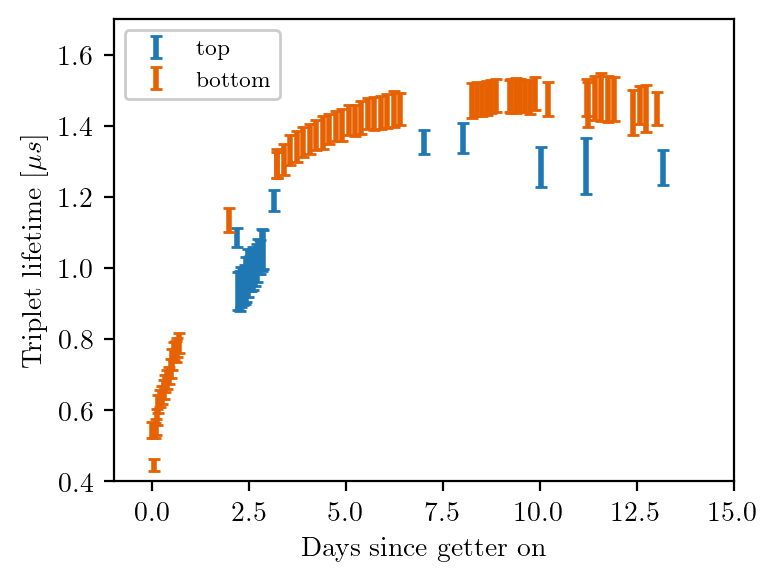

In [20]:
for i,p in enumerate(pos):
    plt.errorbar(days[i], np.array(triplet[i])[:,0], yerr=np.array(triplet[i])[:,1], label=p, ls='none')
plt.legend()
plt.xlim(-1, 15)
plt.ylim(0.4,1.7)
plt.xlabel('Days since getter on')
plt.ylabel(r'Triplet lifetime [$\mu s$]')